In [1]:
from pymdp.agent import Agent
from typing import Sequence, Optional

import mctx

import jax.numpy as jnp
import jax.tree_util as jtu
import jax.random as jr
import jax.nn as nn

import chex
import pygraphviz

from IPython.display import SVG

Utility function to convert and display the MCTX output to an SVG visualization of the search tree.

In [2]:
def convert_tree_to_graph(
    tree: mctx.Tree,
    action_labels: Optional[Sequence[str]] = None,
    batch_index: int = 0
) -> pygraphviz.AGraph:
  """Converts a search tree into a Graphviz graph.

  Args:
    tree: A `Tree` containing a batch of search data.
    action_labels: Optional labels for edges, defaults to the action index.
    batch_index: Index of the batch element to plot.

  Returns:
    A Graphviz graph representation of `tree`.
  """
  chex.assert_rank(tree.node_values, 2)
  batch_size = tree.node_values.shape[0]
  if action_labels is None:
    action_labels = range(tree.num_actions)
  elif len(action_labels) != tree.num_actions:
    raise ValueError(
        f"action_labels {action_labels} has the wrong number of actions "
        f"({len(action_labels)}). "
        f"Expecting {tree.num_actions}.")

  def node_to_str(node_i, reward=0, discount=1):
    return (f"{node_i}\n"
            f"Reward: {reward:.2f}\n"
            f"Discount: {discount:.2f}\n"
            f"Value: {tree.node_values[batch_index, node_i]:.2f}\n"
            f"Visits: {tree.node_visits[batch_index, node_i]}\n")

  def edge_to_str(node_i, a_i):
    node_index = jnp.full([batch_size], node_i)
    probs = nn.softmax(tree.children_prior_logits[batch_index, node_i])
    return (f"{action_labels[a_i]}\n"
            f"Q: {tree.qvalues(node_index)[batch_index, a_i]:.2f}\n"  # pytype: disable=unsupported-operands  # always-use-return-annotations
            f"p: {probs[a_i]:.2f}\n")

  graph = pygraphviz.AGraph(directed=True)

  # Add root
  graph.add_node(0, label=node_to_str(node_i=0), color="green")
  # Add all other nodes and connect them up.
  for node_i in range(tree.num_simulations):
    for a_i in range(tree.num_actions):
      # Index of children, or -1 if not expanded
      children_i = tree.children_index[batch_index, node_i, a_i]
      if children_i >= 0:
        graph.add_node(
            children_i,
            label=node_to_str(
                node_i=children_i,
                reward=tree.children_rewards[batch_index, node_i, a_i],
                discount=tree.children_discounts[batch_index, node_i, a_i]),
            color="red")
        graph.add_edge(node_i, children_i, label=edge_to_str(node_i, a_i))

  return graph

Let's test it on the graph world example as well.

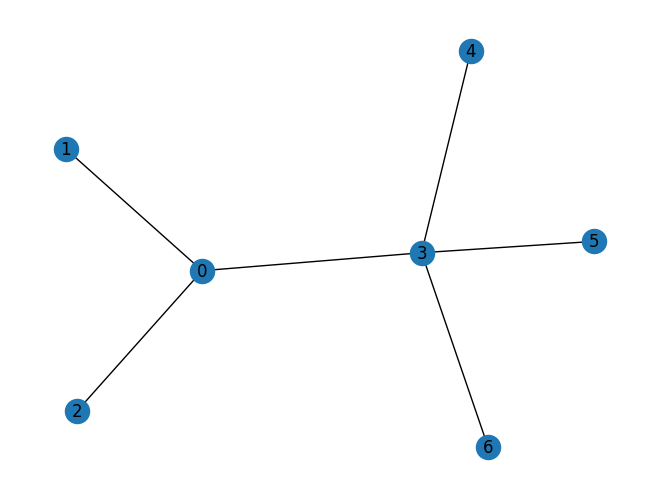

In [3]:
import networkx as nx
from pymdp.envs import GraphEnv
from pymdp.envs.graph_worlds import generate_connected_clusters

graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
env = GraphEnv(graph, object_locations=[4], agent_locations=[0])

nx.draw(graph, with_labels=True)

We set the initial location of the agent at node 1, and prior belief that the object is at node 4. Therefore, the expected rewarding path is 1 -> 0 -> 3 -> 4.

In [4]:
A = [a for a in env.params["A"]]
B = [b for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[:, 1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]
D[0] = D[0].at[0, 1].set(100.0)
D[1] = D[1].at[0, 4].set(10.0)
D = jtu.tree_map(lambda x: x / x.sum(), D)


batch_size = A[0].shape[0]

agent = Agent(
    A,
    B,
    C,
    D,
    None,
    None,
    None,
    A_dependencies=A_dependencies,
    B_dependencies=B_dependencies,
    onehot_obs=False,
    apply_batch=False
)

In [5]:
import mctx
from pymdp.planning.mcts import make_aif_recurrent_fn

recurrent_fn = make_aif_recurrent_fn()
rng_key = jr.PRNGKey(111)

[[1.0000000e+00 3.8881731e-10 3.4560806e-15 1.7227886e-17 1.0527664e-09
  1.3362416e-09 6.4221889e-10]]


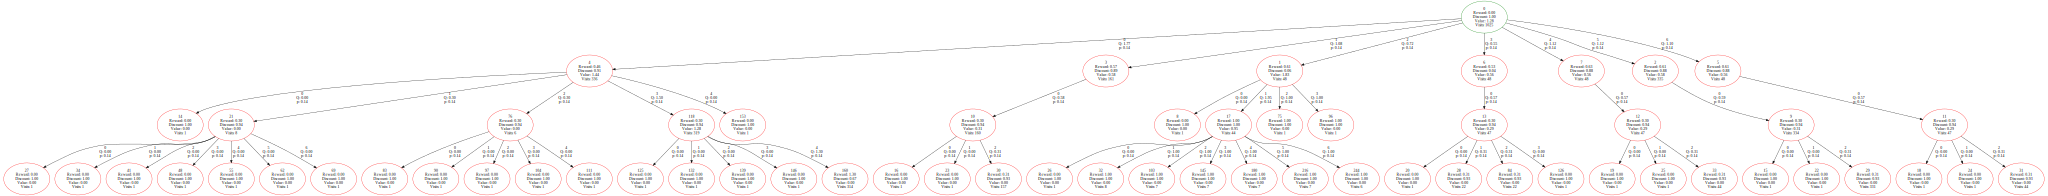

In [6]:
# %%timeit
root = mctx.RootFnOutput(
    prior_logits=jnp.log(agent.E),
    value=jnp.zeros((agent.batch_size)),
    embedding=agent.D,
)

policy_output = mctx.gumbel_muzero_policy(
    agent,
    rng_key,
    root,
    recurrent_fn,
    num_simulations=1024,
    max_depth=3
)

tree_gumbel = policy_output.search_tree
print(policy_output.action_weights)

graph = convert_tree_to_graph(tree_gumbel)
svg = graph.draw(format='svg', prog='dot').decode(graph.encoding)
SVG(svg)